In [211]:
import pandas as pd
import numpy as np

import missingno as msno
from summarytools import dfSummary
import seaborn as sns

In [205]:
rent = pd.read_csv("olx_20230820.csv", encoding='latin')

# Data Wrangling and Cleaning

In [206]:
rent.head()

,aluguel,CEP,Município,Bairro,Logradouro,Condomínio,IPTU,Tamanho,Vagas na garagem,Área útil,Banheiros,Tipo,Aluguel + Condomínio,Detalhes do imóvel,Detalhes do condomínio,Área construída,Acomoda,Características
0,1.500,22020001,Rio de Janeiro,Copacabana,Avenida Nossa Senhora de Copacabana - de 46 a ...,R$ 840,R$ 123,45m²,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.300,20091005,Rio de Janeiro,Centro,Rua da Quitanda - de 79/80 ao fim,R$ 1.950,R$ 790,150m²,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,450,20260132,Rio de Janeiro,Estácio,Rua Haddock Lobo - até 120 - lado par,R$ 756,R$ 103,33m²,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000,21050700,Rio de Janeiro,Higienópolis,Rua Astreia,R$ 320,R$ 0,NaN,NaN,60m²,1,Padrão,R$ 1.320,NaN,NaN,NaN,NaN,NaN
4,3.200,22620311,Rio de Janeiro,Barra da Tijuca,Avenida Prefeito Dulcídio Cardoso - de 304 a 1...,R$ 1.250,R$ 250,NaN,1,65m²,2,Padrão,R$ 4.450,"Academia, Ar condicionado, Área de serviço, Ar...","Academia, Condomínio fechado, Elevador, Permit...",NaN,NaN,NaN


In [207]:
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   aluguel                 4990 non-null   object 
 1   CEP                     5000 non-null   int64  
 2   Município               5000 non-null   object 
 3   Bairro                  4950 non-null   object 
 4   Logradouro              4839 non-null   object 
 5   Condomínio              4791 non-null   object 
 6   IPTU                    4776 non-null   object 
 7   Tamanho                 2215 non-null   object 
 8   Vagas na garagem        4032 non-null   object 
 9   Área útil               1776 non-null   object 
 10  Banheiros               2740 non-null   object 
 11  Tipo                    2775 non-null   object 
 12  Aluguel + Condomínio    2088 non-null   object 
 13  Detalhes do imóvel      1798 non-null   object 
 14  Detalhes do condomínio  1622 non-null   

<Axes: >

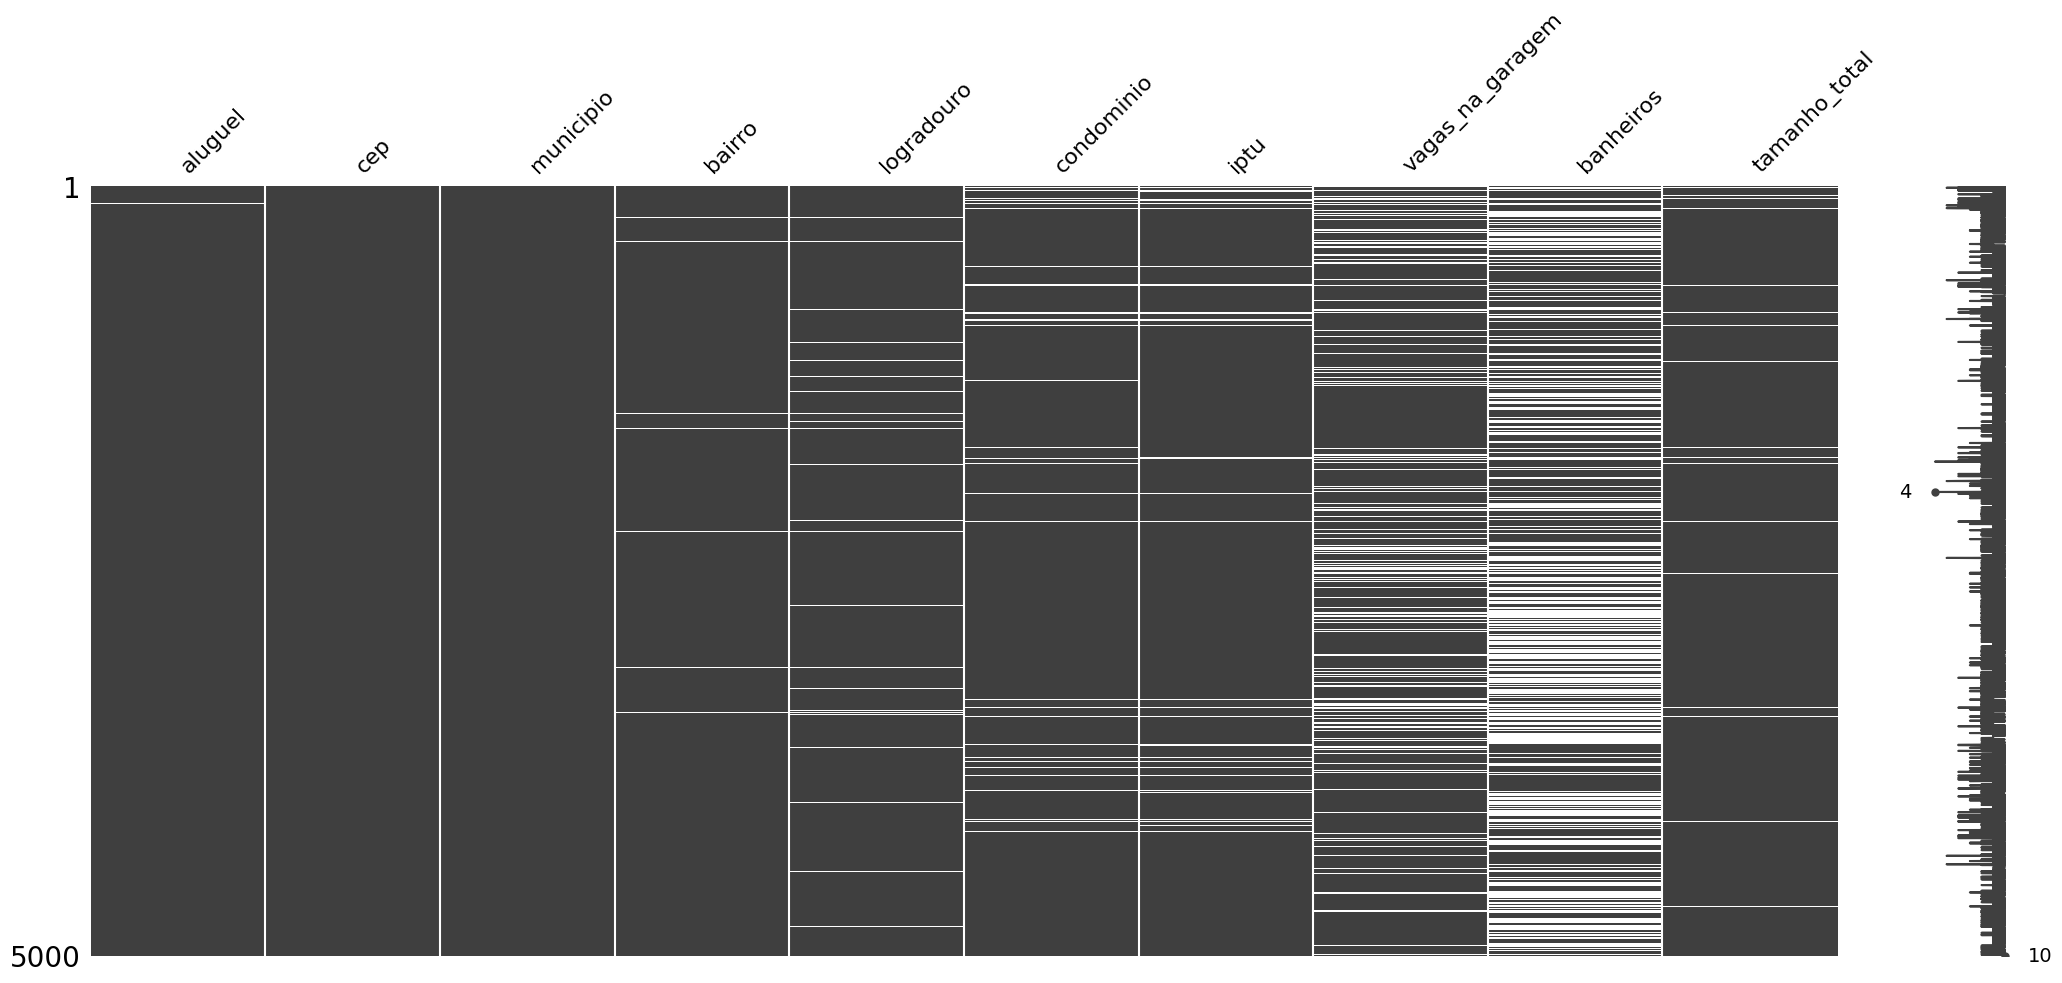

In [212]:
msno.matrix(rent)

In [213]:
pd.DataFrame({
    'Missings (N)': rent.isnull().sum(),
    'Missings (%)': rent.isnull().mean() * 100
})

,Missings (N),Missings (%)
aluguel,10,0.20
cep,0,0.00
municipio,0,0.00
bairro,50,1.00
logradouro,161,3.22
condominio,209,4.18
iptu,224,4.48
vagas_na_garagem,968,19.36
banheiros,2260,45.20
tamanho_total,132,2.64


In [208]:
# fixing variable names
rent.columns = (rent.columns
                .str.lower()
                .str.replace(" ", "_", regex=False)
                .str.normalize('NFKD')
                .str.encode('ascii', errors='ignore')
                .str.decode('utf-8'))

In [209]:
# rent as numerical variable
rent['aluguel'] = rent['aluguel'].str.replace(r'\.', '', regex=True).astype(float)

# fixing other numerical variables
for col in ['condominio', 'iptu', 'aluguel_+_condominio']:
    rent[col] = (rent[col]
                 .str.replace("R$ ", "", regex=False)
                 .replace(r'\.', '', regex=True).astype(float))
    
for col in ['tamanho', 'area_util', 'area_construida']:
    rent[col] = (rent[col]
                .astype(str)
                .str.replace("m²", "", regex=True)
                .str.strip()
                .replace({"": None})
                .astype(float))

rent['logradouro'] = rent['logradouro'].str.split(' - ', n=1, expand=True)[0].str.strip()
    
rent['tamanho_total'] = rent[['tamanho', 'area_util', 'area_construida']].sum(axis=1, min_count=1)

for col in ['vagas_na_garagem', 'banheiros']:
    rent[col] = (rent[col]
                .astype(str)
                .str.replace(" ou mais", "", regex=True)
                .str.strip()
                .replace({"": None})
                .astype(float))
    
for col in ['cep', 'municipio', 'bairro', 'logradouro']:
    rent[col] = rent[col].astype('category')

rent = rent.drop(columns=['caracteristicas', 'acomoda', 'detalhes_do_condominio', 'detalhes_do_imovel', 'tipo', 'aluguel_+_condominio', 'tamanho', 'area_util', 'area_construida'])

In [210]:
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   aluguel           4990 non-null   float64 
 1   cep               5000 non-null   category
 2   municipio         5000 non-null   category
 3   bairro            4950 non-null   category
 4   logradouro        4839 non-null   category
 5   condominio        4791 non-null   float64 
 6   iptu              4776 non-null   float64 
 7   vagas_na_garagem  4032 non-null   float64 
 8   banheiros         2740 non-null   float64 
 9   tamanho_total     4868 non-null   float64 
dtypes: category(4), float64(6)
memory usage: 453.2 KB


In [214]:
rent.duplicated().sum()
rent = rent.drop_duplicates(keep='first')


<Axes: xlabel='tamanho_total', ylabel='Count'>

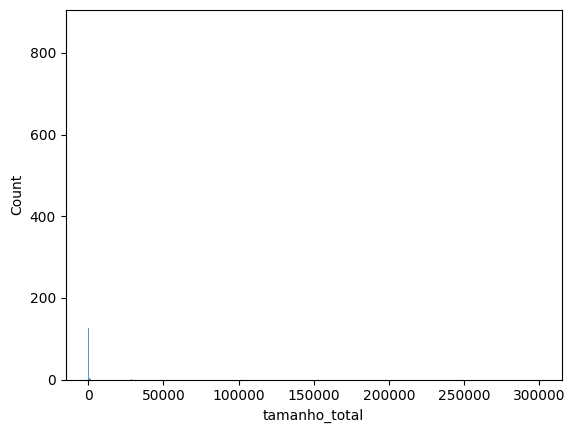

In [217]:
sns.histplot(data=rent, x='tamanho_total')